In [9]:
from sklearn import random_projection
from sklearn.mixture import GaussianMixture
from sklearn import cluster, datasets
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA as pca
import time
%matplotlib inline
import bokeh.plotting as bp
from sklearn.manifold import TSNE
from bokeh.models import HoverTool
from bokeh.io import output_notebook
from collections import Counter
from sklearn.cluster import KMeans
output_notebook()

Loading BokehJS ...

In [2]:
plt.rc("figure", figsize=(9, 4))

## Motivation

Random projection (RP) is a commonly used dimensionality reduction technique. As a relatively young technique that was invented around 1980, RP gains a lot of tractions becuase it doesn't require a lot of computational power and it has beend shown to have some promises for various applications such as high dimensional clustering, image and text data dimension reductions(Fern & Brodley, 2003; Bingham & Mannila, 2001). In this post, we are going explore RP's mathematical meaning, as well as some implementations of RP using python.


## Where & How

RP comes from a famous lemma called the Johnson-Lindenstrauss lemma. Based on the Johnson-Lindenstrauss lemma, one can project a high-dimensional data onto a lower dimensional subspace using a random matrix because the distances between points are approximately preserved. When putting into mathematical prospective, the original matrix D is projected onto P using a random matrix R.   

$$P = R \times D$$

The basic dimension is shown as below,  
  
$$ \left[\begin{array}
{rrr}
 &  &  \\
 & Projected &  \\
 &  & 
\end{array}\right]_{k \times n} = \left[\begin{array}
{rrr}
 &  &  \\
 & Random &  \\
 &  & 
\end{array}\right]_{k \times d}\left[\begin{array}
{rrr}
 &  &  \\
 & Original &  \\
 &  & 
\end{array}\right]_{d \times n}
$$  

where k << d. Each entry of the random matrix R is sampled from an standard normal distribution and is normalized by the columns to a unit length. A way to think about each column of R is as random "weights" to decompose D. 

Achlioptas (Achlioptas, 2001) provides another method to fill in values for R that theoratically meets the requirment for the Johnson-Lindenstrauss lemma:  

$$r_ij = \sqrt3 \Bigg\{\begin{array}
{rrr}
 +1&  & probability = \frac{1}{6} \\
 0& & probability = \frac{2}{3} \\
 -1 &  & probability = \frac{1}{6}
\end{array}
$$

, where we called R a **sparse** matrix. Achlioptas's finding help further computational saving with easier-to-simulate matrix. Below, we will compare the two methods of populating R and see if Achlioptas's finding can be used in practice. 

## Why

Why do we want to use RP and what is its limitations compared to the widely known dimension reduction method, PCA? 

The dataset we are going to explore is [CHART](https://archive.ics.uci.edu/ml/datasets/Synthetic+Control+Chart+Time+Series). CHART contains 600 examples of control charts synthetically generated by the process in Alcock and Manolopoulos (1999). There are six different classes of control charts: 

    A. Normal 
    B. Cyclic 
    C. Increasing trend 
    D. Decreasing trend 
    E. Upward shift 
    F. Downward shift 

Here is a image provided by UCI showing the different classes in picture.
<img src="image/chart_class.jpeg" alt="term-document matrix" style="width: 80%"/>

In [4]:
df = pd.read_table('synthetic_control_data.txt',sep='\s+',header=None)
print df.shape

(600, 60)


In [6]:
def RP(component):
    RP = random_projection.SparseRandomProjection(n_components=component)
    return RP

def PCA(component):
    p = pca(n_components=component)
    return p


## define KNN to have 6 neighbors
neigh = KNeighborsClassifier(n_neighbors=6)

In [77]:
components = range(1,15,1) 
names = ['rp','pca']
name2func = {'rp':'RP','pca':'PCA'}
summary = pd.DataFrame(index=pd.MultiIndex.from_product([['RP','PCA'],components ],
                                                        names=['method','n_component']),
             columns=['Time','Accuracy'])

for name in names: # use both random projection and PCA
    for component in components:# reduce dimension to number within 1 to 15

        fcn = name2func[name]
        ## measure run time
        start_time = time.time()
        df_ = pd.DataFrame(locals()[fcn](component).fit_transform(df))
        summary.loc[(fcn,component),'Time'] =time.time() - start_time 
        
        ## measure accuracy 
        df_['y_true'] = np.array(sum([[i]*100 for i in range(6)],[]))
        neigh = KNeighborsClassifier(n_neighbors=6)
        neigh.fit(df_.iloc[:,:-1],df_.iloc[:,-1]) 
        df_['y_pred'] = neigh.predict(df_.iloc[:,:-1])
        summary.loc[(fcn,component),'Accuracy'] = accuracy_score(df_.y_true,df_.y_pred)



#### Time

method
PCA    Axes(0.125,0.125;0.775x0.755)
RP     Axes(0.125,0.125;0.775x0.755)
Name: Time, dtype: object

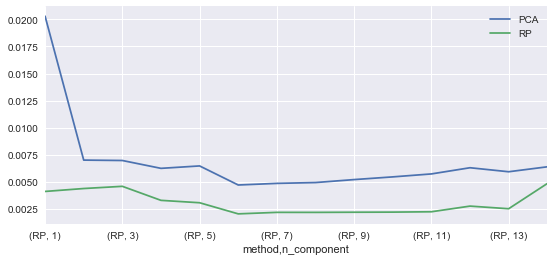

In [76]:
summary.groupby(level='method').Time.plot(legend=True)


When we reduce dimension from 60 to a smaller number, random projection is always faster. Especially when we reduce dimension to 1, random projection is about four times faster than PCA.


#### Accuracy

method
PCA    Axes(0.125,0.125;0.775x0.755)
RP     Axes(0.125,0.125;0.775x0.755)
Name: Accuracy, dtype: object

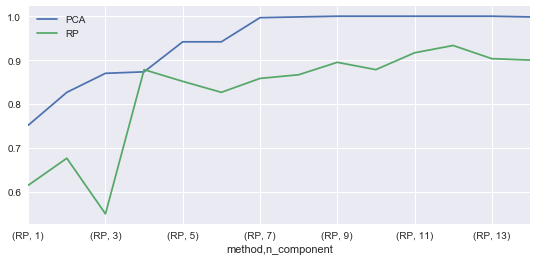

In [66]:
summary.groupby(level='method').Accuracy.plot(legend=True)

However, PCA are almost always more accurate than RP. PCA is going after the best/perfect seperation to retain the distance from high dimension whereas RP gives a stochastic answer to dimension reduction. 

So we conclude:

|        | Advantage | Disadvantage |
| ------------- | ------------- |------------- |
| RP  | Fast  | Stochastic solution |
| PCA  | Slow  |Perfect solution |

## RP and its applications
### High dimensional unsupervised clustering

As google dictionary suggests, clustering means grouping similar things together. This is hard for dataset with high dimensionality. Give you a concrete example. In situation A, there are two points in a 200 dimensional world: two points are very close in the x,y,z dimension and yet not similar at all in the other 197 dimensions. How should the machine cluster those two points? Are they extremely similar or not? However, in situation B, you are given two points in a 1 dimensional world: one point is at 1.0 and another is at 1.01. To cluster those two points, you just have to look at the euclidean disctance (1.01-1.0) between the two and the euclidean disctance of those two points with the rest of the dataset. Hence, for a high dimensional dataset, we want to reduce the dimensionality before clustering. As Fern (Fern & Brodley, 2003) suggests, an cluster ensemble framework based on RP and expectation-maximization (EM) proved its effectiveness for high dimensional data clustering. 

Without reshown their work, we are going to do something a little bit different --  **visualize the clustering**


 #### step 1 - reduce dimension using RP 

In [7]:
transformer = RP(6) ## reduce dimension
df_sparse = transformer.fit_transform(df) 
df_sparse.shape

(600, 6)

 #### step 2 - use T-SNE to visualize high dimensional data
 On [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) website, it wrote
 
 
     t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points
     to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint
     probabilities of the low-dimensional embedding and the high-dimensional data.

In [10]:
## visualize 6-dimension data into x and y coordinate
xycoords = TSNE().fit_transform(df_sparse) 
xycoords.shape

(600, 2)

#### step 3 - use unsupervised clustering method to identify cluster

In [11]:
n_clusters = 6 ## is a given (we are cheating a little bit here)
km = KMeans(n_clusters)
clusters = km.fit_predict(df_sparse)

#### step 4 - identify cluster using given label

We are given labels for CHART data. The first 100 rows are normal, the second 100 rows are cyclic and so on...  
We look at what K-mean result looks like and find the most common label for the first 100 rows, second 100 rows, and so on. If two clusters share the same label, then we will look over the two clusters and decide by eye-picking. 


In [12]:
def most_common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

chunks = [clusters[x:x+100] for x in xrange(0, len(clusters), 100)]

class_name = [most_common(i) for i in chunks]
class_name

[4, 4, 2, 0, 3, 5]

In [13]:
chunks[0:2]

[array([4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4], dtype=int32),
 array([1, 4, 1, 1, 4, 4, 4, 1, 4, 1, 1, 1, 4, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1,
        4, 1, 4, 1, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 3, 1, 4, 4, 1, 1, 1, 4, 4,
        1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 1, 1, 4, 4, 1, 4, 4, 4, 4,
        4, 4, 4, 4, 1, 4, 1, 4, 1, 1, 1, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 1,
        4, 4, 1, 4, 4, 1, 1, 4], dtype=int32)]

In [14]:
class_name[1]=1

Since cluster[0] and cluster[1] shares the same label, we have to make changes
#### step 5 - use bokeh to visualize the data

The points are situated based on the x and y coordinates derided from step 1 and colored by K-mean cluster.   
The pop-up is color-coded and denoted by the class labels we assign (given the fact that we know there are 6 classes and each 100 rows represent a different class.) 

In [16]:
colormap = np.array([
    "#dbdb8d", "#9edae5", "#ff7f0e", "#c5b0d5", "#2ca02c", 
    "#c49c94"
])
names = sum([[i]*100 for i in class_name],[])
color = sum([[colormap[i]]*100 for i in class_name],[])

In [17]:
source=bp.ColumnDataSource({"classtype": names,'color':color})

hover = HoverTool(tooltips='''        
<div>
            <p style="font-size: 17px;color: @color;">class: <span style="font-size: 17px; font-weight: bold;color: @color;">@classtype</span></p>
        
</div>''')

p = bp.figure(plot_width=900, plot_height=400, title="CHART Map by t-SNE",
       tools=[hover],
       x_axis_type=None, y_axis_type=None, min_border=1)
p.scatter(
    x = xycoords[:,0],
    y = xycoords[:,1],
    size=8,
    color= colormap[clusters],
    source=source)
bp.show(p)

If a point has the same color as the pop-up notation, then we correctly cluster that point. On the other hand, if a point has a different color than that of the pop-up notation, then we do not correctly identify the right cluster for that point.
